# LangGraph

https://docs.langchain.com/oss/python/langgraph/workflows-agents

In [1]:
import random
from typing import Literal, Annotated

import nest_asyncio
from dotenv import load_dotenv
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
# Third-party imports
from typing_extensions import TypedDict

# Load environment variables
load_dotenv(override=True)

# Apply nest_asyncio for Jupyter compatibility (if needed)
nest_asyncio.apply()

In [2]:
# ===== PART 1: GRAPHS AS SEQUENCES OF ACTIONS =====
# Graphs are sequences of actions, like steps in a process.
# These actions can be simple functions, language model modules, or entire subgraphs.

# ===== SIMPLE FUNCTIONS WITH STATES =====
# Each node is a function that modifies the graph state.
# State is represented by a dictionary storing variables and their values.

class State(TypedDict):
    graph_state: str

In [3]:
# ===== NODES =====
# Nodes are where functions change the state of the graph.
# Starting with elementary functions.

def node_1(state):
    print("--- Node 1 ---")
    return {"graph_state": state['graph_state'] + " I am"}


def node_2(state):
    print("--- Node 2 ---")
    return {"graph_state": state['graph_state'] + " happy :)"}


def node_3(state):
    print("--- Node 3 ---")
    return {"graph_state": state['graph_state'] + " sad :("}

In [4]:
# ===== EDGES =====
# Nodes are connected through edges that define task flow.
# They can be direct or conditional relationships.

def mood_decision(state) -> Literal["Node_2", "Node_3"]:
    """Conditional edge function that randomly decides the next node"""
    # Often the next step depends on the state
    # In this example, we use random choice but could analyze state['graph_state']

    # Let chance decide whether to choose node 2 or 3
    random_number = random.random()
    print(f"Random number: {random_number}")

    if random_number < 0.5:
        # 50% chance to choose node_2
        return "Node_2"

    # 50% chance to choose Node_3
    return "Node_3"

In [5]:
# ===== GRAPH CONSTRUCTION =====
# Design and create our simple graph

"""Create a simple graph with conditional routing"""
builder = StateGraph(State)
builder.add_node("Node_1", node_1)
builder.add_node("Node_2", node_2)
builder.add_node("Node_3", node_3)

builder.add_edge(START, "Node_1")
builder.add_conditional_edges("Node_1", mood_decision)
builder.add_edge("Node_2", END)
builder.add_edge("Node_3", END)

graph = builder.compile()

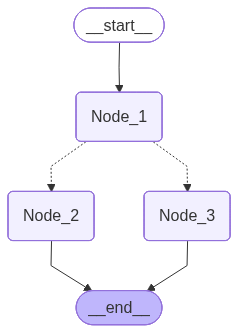

In [6]:
from IPython.display import Image

png_bytes = graph.get_graph().draw_mermaid_png()
Image(png_bytes)

In [7]:
# ===== EXECUTION =====
"""Execute the simple graph with sample input"""

result = graph.invoke({"graph_state": "Hello, I am Tom."})
print(f"Final result: {result}")

--- Node 1 ---
Random number: 0.8205245186185273
--- Node 3 ---
Final result: {'graph_state': 'Hello, I am Tom. I am sad :('}


In [8]:
# ===== PART 2: LANGUAGE MODEL AS A COMPONENT =====

# Initialize OpenAI language model
"""Initialize ChatOpenAI with API key from environment"""
llm = AzureChatOpenAI(model="gpt-4o-mini")


# Message state for handling conversation history
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [9]:
def pure_llm(state: MessagesState):
    """Node that processes messages through the language model"""
    return {"messages": [llm.invoke(state["messages"])]}

In [10]:
# Build graph
builder = StateGraph(MessagesState)
builder.add_node("Pure_LLM", pure_llm)

builder.add_edge(START, "Pure_LLM")
builder.add_edge("Pure_LLM", END)

graph = builder.compile()

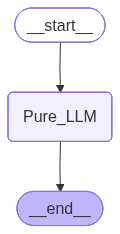

In [11]:
from IPython.display import Image

png_bytes = graph.get_graph().draw_mermaid_png()
Image(png_bytes)

In [12]:
"""Execute the LLM graph with a sample question"""

result = graph.invoke({"messages": HumanMessage(content="Tell me about Paris")})

# Print the conversation
for message in result['messages']:
    if hasattr(message, 'content'):
        print(f"Message type: {type(message).__name__}")
        print(f"Content:")
        print(f"{message.content}")
        print("---")

Message type: HumanMessage
Content:
Tell me about Paris
---
Message type: AIMessage
Content:
Paris, the capital of France, is one of the most famous cities in the world. Known as "La Ville Lumière" (The City of Light), it has a rich history and is renowned for its art, fashion, gastronomy, and culture. Here are some key highlights about Paris:

### 1. **Historical Significance**:
   - Paris has a history that dates back over 2,000 years. It was founded by a Celtic tribe known as the Parisii in the 3rd century BC.
   - The city has witnessed significant historical events, including the French Revolution and two World Wars, shaping its modern identity.

### 2. **Landmarks and Architecture**:
   - **Eiffel Tower**: A global symbol of Paris, built in 1889 for the Exposition Universelle.
   - **Louvre Museum**: The world's largest art museum, home to thousands of works, including the Mona Lisa and the Venus de Milo.
   - **Notre-Dame Cathedral**: An iconic gothic cathedral, currently underg

In [13]:
import operator
from typing import Any

print("=== PART 1: SIMPLE ASYNCHRONOUS PROCESS ===")
print("Nodes introduce themselves and add their name to a single list")
print()


# State definition for simple example
class SimpleState(TypedDict):
    state: Annotated[list, operator.add]


class ReturnNodeValue:
    """Class representing a node that adds its value to the state"""

    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: SimpleState) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}


# Creating graph for simple example
simple_builder = StateGraph(SimpleState)

# Adding nodes with unique names
simple_builder.add_node("a", ReturnNodeValue("I am A"))
simple_builder.add_node("b", ReturnNodeValue("I am B"))
simple_builder.add_node("c", ReturnNodeValue("I am C"))
simple_builder.add_node("d", ReturnNodeValue("I am D"))

# Flow definition - nodes b and c run in parallel after a
simple_builder.add_edge(START, "a")
simple_builder.add_edge("a", "b")  # parallel execution
simple_builder.add_edge("a", "c")  # parallel execution
simple_builder.add_edge("b", "d")
simple_builder.add_edge("c", "d")
simple_builder.add_edge("d", END)

simple_graph = simple_builder.compile()

=== PART 1: SIMPLE ASYNCHRONOUS PROCESS ===
Nodes introduce themselves and add their name to a single list



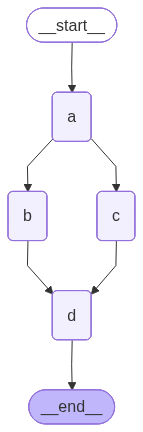

In [14]:
from IPython.display import Image

png_bytes = simple_graph.get_graph().draw_mermaid_png()
Image(png_bytes)

In [15]:
# Running simple example
print("Running simple asynchronous graph:")
simple_result = simple_graph.invoke({"state": []})
print(f"Result: {simple_result}")
print()

Running simple asynchronous graph:
Adding I am A to []
Adding I am B to ['I am A']
Adding I am C to ['I am A']
Adding I am D to ['I am A', 'I am B', 'I am C']
Result: {'state': ['I am A', 'I am B', 'I am C', 'I am D']}



UWAGA: Trzeba wygenerować klucz API do tavily

https://help.tavily.com/articles/9170796666-how-can-i-create-an-api-key

In [16]:
print("=== PART 2: PARALLEL PROCESSING WITH LLM ===")
print("System answers questions using two sources: Internet (Tavily) and Wikipedia")
print()


# State definition for search example
class SearchState(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

=== PART 2: PARALLEL PROCESSING WITH LLM ===
System answers questions using two sources: Internet (Tavily) and Wikipedia



In [17]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [18]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults


def search_web(state):
    """Search internet resources using Tavily"""

    print("... Searching internet resources using Tavily ... \n")

    # Internet search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

    # Format results
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_wikipedia(state):
    """Search Wikipedia resources"""

    print("... Searching Wikipedia resources ... \n")

    # Wikipedia search
    search_docs = WikipediaLoader(
        query=state['question'],
        load_max_docs=2
    ).load()

    # Format results
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_answer(state):
    """Generate answer based on collected context"""

    # Get state
    context = state["context"]
    question = state["question"]

    # Answer template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(
        question=question,
        context=context
    )

    # Generate answer
    answer = llm.invoke([
        SystemMessage(content=answer_instructions),
        HumanMessage(content="Answer the question.")
    ])

    return {"answer": answer}

In [19]:
# Creating search graph
search_builder = StateGraph(SearchState)

# Adding nodes
search_builder.add_node("search_internet", search_web)
search_builder.add_node("search_wikipedia", search_wikipedia)
search_builder.add_node("generate_answer", generate_answer)

# Flow definition - searches run in parallel
search_builder.add_edge(START, "search_wikipedia")  # parallel execution
search_builder.add_edge(START, "search_internet")  # parallel execution
search_builder.add_edge("search_wikipedia", "generate_answer")
search_builder.add_edge("search_internet", "generate_answer")
search_builder.add_edge("generate_answer", END)

search_graph = search_builder.compile()

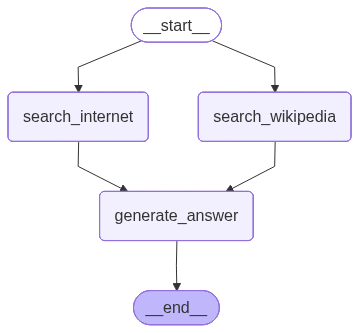

In [20]:
from IPython.display import Image

png_bytes = search_graph.get_graph().draw_mermaid_png()
Image(png_bytes)

In [21]:
# Example question to demonstrate the system
example_question = "What is a business potential of LLM-based multi-agent systems in banking? Suggest the most interesting business cases"

print(f"Asking question: {example_question}")
print()

# Run search and answer generation
search_result = search_graph.invoke({"question": example_question})

print("=== ANSWER ===")
print(search_result['answer'].content)
print()

Asking question: What is a business potential of LLM-based multi-agent systems in banking? Suggest the most interesting business cases

... Searching internet resources using Tavily ... 

... Searching Wikipedia resources ... 



/tmp/ipykernel_56192/3109019915.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


=== ANSWER ===
The business potential of LLM-based multi-agent systems (MAS) in banking is significant due to their ability to enhance decision-making, improve efficiencies, and deliver personalized customer experiences. Utilizing LLMs, these specialized agents can mimic human-like reasoning and tackle complex tasks autonomously. Here are some interesting business cases that could emerge from this context:

1. **Personalized Financial Advisory**: LLM-powered MAS can be employed to create personalized financial advisors that assess individual customer profiles using their transaction history, spending habits, and risk appetites. This system can provide tailored investment recommendations, savings plans, and financial goal tracking.

2. **Automated Loan Approval Processes**: A multi-agent system can streamline loan processing by having agents that collect and analyze relevant data from multiple sources (credit scores, income, and loan history) and communicate with each other to expedite 

In [22]:
print("=== CONTEXT INFORMATION ===")
print(f"Collected {len(search_result['context'])} information sources:")
for i, context in enumerate(search_result['context'], 1):
    print(f"Source {i}: {len(context)} characters")

=== CONTEXT INFORMATION ===
Collected 2 information sources:
Source 1: 3410 characters
Source 2: 8201 characters


In [23]:
type(search_result)

dict

In [24]:
search_result.keys()

dict_keys(['question', 'answer', 'context'])

ZADANIE: Uruchomić skrypty powyżej oraz przestudiować plik `3_map_reduce.py` (architektura map-reduce)

# Tools

In [25]:
from langchain_core.tools import tool
import json


@tool
def get_current_weather(location: str, unit: str = "fahrenheit") -> str:
    """
    Get the current weather in a given location.

    Args:
        location: The city and state, e.g. San Francisco, CA.
        unit: The unit of temperature, can be 'celsius' or 'fahrenheit'. Defaults to 'fahrenheit'.
    """
    weather_info = {
        "location": location,
        "temperature": "72",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }
    return json.dumps(weather_info)


@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two numbers together.

    Args:
        a: First number to multiply
        b: Second number to multiply
    """
    print(f"Multiplying {a} × {b} = {a * b}")
    return a * b


@tool
def add(a: int, b: int) -> int:
    """
    Add two numbers together.

    Args:
        a: First number to add
        b: Second number to add
    """
    print(f"Adding {a} + {b} = {a + b}")
    return a + b

In [26]:
# ================================
# EXAMPLE 1: BASIC TOOL USAGE (MANUAL)
# ================================

print("=== EXAMPLE 1: Manual Tool Execution ===")

# Bind tools to model
model_with_tools = llm.bind_tools([get_current_weather, multiply])

# Get model response with tool calls
response = model_with_tools.invoke("What's the weather in San Francisco?")

=== EXAMPLE 1: Manual Tool Execution ===


In [27]:
print("Model response:")
print(f"Content: {response.content}")
print(f"Tool calls: {response.tool_calls}")

Model response:
Content: 
Tool calls: [{'name': 'get_current_weather', 'args': {'location': 'San Francisco, CA'}, 'id': 'call_0gjJvKhqIwqsV7KNjSGPaNRi', 'type': 'tool_call'}]


In [28]:
if response.tool_calls:
    tool_call = response.tool_calls[0]
    print(f"\nTool to call: {tool_call['name']}")
    print(f"Arguments: {tool_call['args']}")

    # Manual execution using LangChain tool invoke method
    if tool_call['name'] == 'get_current_weather':
        result = get_current_weather.invoke(tool_call['args'])
        print(f"Manual execution result: {result}")


Tool to call: get_current_weather
Arguments: {'location': 'San Francisco, CA'}
Manual execution result: {"location": "San Francisco, CA", "temperature": "72", "unit": "fahrenheit", "forecast": ["sunny", "windy"]}


In [29]:
# ================================
# EXAMPLE 2: MODEL WITHOUT TOOLS
# ================================

print("\n=== EXAMPLE 2: Model Without Tools ===")

response = llm.invoke("What's the weather in San Francisco?")
print("Response without tools:")
print(response.content)


=== EXAMPLE 2: Model Without Tools ===


Response without tools:
I'm unable to provide real-time weather updates. To get the current weather in San Francisco, I recommend checking a reliable weather website or app.


In [30]:
from langchain.agents import create_agent
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

tools = [get_current_weather, multiply, add]
agent = create_agent(llm, tools)

print("Query: What's 5 multiplied by 8?")
print()
result = agent.invoke({"messages": ["What's 5 multiplied by 8?"]})

for message in result['messages']:
    if isinstance(message, AIMessage):
        print("AI Message:")
        if message.content:
            print(f"Content: {message.content}")
        if message.additional_kwargs.get("tool_calls"):
            print("Tool calls:")
            for tool_call in message.additional_kwargs["tool_calls"]:
                print(f"  Tool to call: {tool_call['function']['name']}")
                print(f"  Arguments: {tool_call['function']['arguments']}")
    elif isinstance(message, ToolMessage):
        print("Tool Message:")
        print(f"  Tool name: {message.name}")
        print(f"  Tool output: {message.content}")

    print("---")

Query: What's 5 multiplied by 8?

Multiplying 5 × 8 = 40
---
AI Message:
Tool calls:
  Tool to call: multiply
  Arguments: {"a":5,"b":8}
---
Tool Message:
  Tool name: multiply
  Tool output: 40
---
AI Message:
Content: 5 multiplied by 8 is 40.
---


In [48]:
# EXAMPLE 3 - TOOLS IN LANGGRAPH


# --- State ---
class State(TypedDict):
    messages: list


# Define LLM with tools
llm_with_tools = llm.bind_tools(tools)


# --- Agent Node ---
def agent_node(state: State):
    system_prompt = """You are a helpful assistant that can use tools to answer user questions."""
    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    state["messages"].append(response)
    return state


# Define tools
tools = [get_current_weather, multiply, add]
tools_by_name = {tool.name: tool for tool in tools}


# Tool Node
def tool_node(state: State):
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        state["messages"].append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return state


# Edge condition to check for tool calls
def should_continue(state: State):
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

In [49]:
builder = StateGraph(State)

builder.add_node("agent_node", agent_node)
builder.add_node("tool_node", tool_node)

builder.add_edge(START, "agent_node")
builder.add_conditional_edges(
    "agent_node",
    should_continue,
    ["tool_node", END]
)
builder.add_edge("tool_node", "agent_node")
builder.add_edge("agent_node", END)

graph = builder.compile()

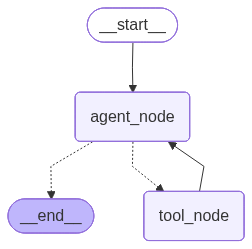

In [50]:
# display graph
png_bytes = graph.get_graph().draw_mermaid_png()
Image(png_bytes)

In [51]:
state = State(messages=[HumanMessage(content="What is the weather in New York and what is 12 multiplied by 7?")])
state = graph.invoke(state)

for message in state['messages']:
    if isinstance(message, AIMessage):
        print("AI Message:")
        if message.content:
            print(f"Content: {message.content}")
        if message.additional_kwargs.get("tool_calls"):
            print("Tool calls:")
            for tool_call in message.additional_kwargs["tool_calls"]:
                print(f"  Tool to call: {tool_call['function']['name']}")
                print(f"  Arguments: {tool_call['function']['arguments']}")
    elif isinstance(message, ToolMessage):
        print("Tool Message:")
        print(f"  Tool name: {message.name}")
        print(f"  Tool output: {message.content}")

    print("---")

Multiplying 12 × 7 = 84
---
AI Message:
Tool calls:
  Tool to call: get_current_weather
  Arguments: {"location": "New York, NY"}
  Tool to call: multiply
  Arguments: {"a": 12, "b": 7}
---
Tool Message:
  Tool name: None
  Tool output: {"location": "New York, NY", "temperature": "72", "unit": "fahrenheit", "forecast": ["sunny", "windy"]}
---
Tool Message:
  Tool name: None
  Tool output: 84
---
AI Message:
Content: The current weather in New York, NY is 72°F, with sunny and windy conditions. 

Additionally, 12 multiplied by 7 is 84.
---


ZADANIE: Uruchomić skrypty z folderu `5. Tools and Agents/1_basic_agents`

Uwaga: Powyższe przykłady są stworzone zgodnie z najnowszym interfejsem biblioteki. Przykłady w folderach mogą wymagać starszych wersji bibliotek (polecam skorzystać z `uv`, gdzie są zapisane konkretne wersje bibliotek).

# GraphRAG

1. Uzupełnij zmienne środowiskowe (dane do neo4j) .env.example -> .env 

2. (optional) Sprawdź ustawienia w utils.config.toml. Uruchom skrypt uv run python 1_generate_data.py (generuje nowe dane)

3. uv run python 2_data_to_knowledge_graph.py 

4. Wejdź pod adres: http://localhost:7474/browser/ ; dane do logowania: neo4j / password123